In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path_w = '../Wimbledon_featured_matches.csv'
df_w = pd.read_csv(path_w)

path_a = '2018-ausopen-points-mixed.csv'
df_a = pd.read_csv(path_a)

In [6]:
# Mapping of similar columns from both datasets
column_mapping = {
    'ElapsedTime': 'elapsed_time',
    'SetNo': 'set_no',
    'P1GamesWon': 'p1_games',
    'P2GamesWon': 'p2_games',
    'GameNo': 'game_no',
    'PointNumber': 'point_no',
    'P1DistanceRun': 'p1_distance_run',
    'P2DistanceRun': 'p2_distance_run',
    'RallyCount': 'rally_count',
    'ServeWidth': 'serve_width',
    'ServeDepth': 'serve_depth',
    'ReturnDepth': 'return_depth',
    'PointWinner': 'point_victor',
    'PointServer': 'server',
    'GameWinner': 'game_victor',
    'SetWinner': 'set_victor',
}

# Renaming columns in the AusOpen dataset
renamed_ausopen_data = df_a.rename(columns=column_mapping)

In [7]:
"""
补充必要的列
"""
def calculate_tennis_scores(df):
    # Initialize columns
    df['p1_sets'] = df['p2_sets'] = df['p1_games'] = df['p2_games'] = 0
    df['p1_score'] = df['p2_score'] = '0'

    # Initialize temporary variables for calculations
    p1_sets = p2_sets = p1_games = p2_games = 0
    p1_points = p2_points = 0

    # Function to reset points and update game score
    def reset_points_and_update_game(winner):
        nonlocal p1_points, p2_points, p1_games, p2_games
        p1_points = p2_points = 0
        if winner == 1:
            p1_games += 1
        else:
            p2_games += 1

    # Function to reset games and update set score
    def reset_games_and_update_set(winner):
        nonlocal p1_games, p2_games, p1_sets, p2_sets
        p1_games = p2_games = 0
        if winner == 1:
            p1_sets += 1
        else:
            p2_sets += 1

    # Function to convert points to tennis score format
    def convert_points_to_score(points):
        if points == 0:
            return '0'
        elif points == 1:
            return '15'
        elif points == 2:
            return '30'
        elif points == 3:
            return '40'
        else:
            return 'A'

    for index, row in df.iterrows():
        # Update the point
        if row['point_victor'] == 1:
            p1_points += 1
        else:
            p2_points += 1

        # Check if a game is won
        if (p1_points >= 4 and p1_points >= p2_points + 2) or (p2_points >= 4 and p2_points >= p1_points + 2):
            reset_points_and_update_game(row['point_victor'])

        # Check if a set is won
        if (p1_games >= 6 and p1_games >= p2_games + 2) or (p2_games >= 6 and p2_games >= p1_games + 2):
            reset_games_and_update_set(row['point_victor'])

        # Update the dataframe
        df.at[index, 'p1_sets'] = p1_sets
        df.at[index, 'p2_sets'] = p2_sets
        df.at[index, 'p1_games'] = p1_games
        df.at[index, 'p2_games'] = p2_games
        df.at[index, 'p1_score'] = convert_points_to_score(p1_points)
        df.at[index, 'p2_score'] = convert_points_to_score(p2_points)

    return df

# Calculate the tennis scores for the AusOpen dataset
updated_ausopen_data = calculate_tennis_scores(renamed_ausopen_data.copy())

def update_set_and_game_victors(df):
    # Initialize columns
    df['set_victor'] = df['game_victor'] = 0

    # Update 'game_victor' based on games won
    last_game_no = 0
    for index, row in df.iterrows():
        if row['game_no'] != last_game_no:
            # Check the previous row to determine the game victor
            if index > 0:
                prev_row = df.iloc[index - 1]
                if prev_row['p1_games'] > (df.iloc[index - 2]['p1_games'] if index - 2 >= 0 else 0):
                    df.at[index - 1, 'game_victor'] = 1
                elif prev_row['p2_games'] > (df.iloc[index - 2]['p2_games'] if index - 2 >= 0 else 0):
                    df.at[index - 1, 'game_victor'] = 2
            last_game_no = row['game_no']

    # Update 'set_victor' based on sets won
    last_set_no = 0
    for index, row in df.iterrows():
        if row['set_no'] != last_set_no:
            # Check the previous row to determine the set victor
            if index > 0:
                prev_row = df.iloc[index - 1]
                if prev_row['p1_sets'] > (df.iloc[index - 2]['p1_sets'] if index - 2 >= 0 else 0):
                    df.at[index - 1, 'set_victor'] = 1
                elif prev_row['p2_sets'] > (df.iloc[index - 2]['p2_sets'] if index - 2 >= 0 else 0):
                    df.at[index - 1, 'set_victor'] = 2
            last_set_no = row['set_no']

    return df


# Update the set_victor and game_victor columns in the AusOpen dataset
updated_ausopen_data = update_set_and_game_victors(updated_ausopen_data)

# save
# updated_ausopen_data.to_csv('new_2018.csv', index=False)

In [8]:
"""
计算综合势头得分函数
"""
def calculate_comprehensive_momentum(data, player_number, window_size=10, alpha=0.02):
    momentum_scores = [0] * len(data)
    consecutive_point_wins = 0  # 追踪连续得分
    consecutive_game_wins = 0  # 追踪连续获胜的局数
    previous_game_winner = None  # 追踪上一局的获胜者
    initial_break_point_value = 1  # 破发的基础势头得分增加值
    ema = 0  # 初始EMA值

    for i in range(1, len(data)):
        recent_data = data[max(0, i - window_size):i]
        momentum_score = 0

        for _, feature in recent_data.iterrows():
            # 基本的势头得分计算
            P_t = 1 if feature['point_victor'] == player_number else -1
            S_t = 1.2 if feature['server'] == player_number else 1.0
            base_momentum = P_t * S_t
            momentum_score += base_momentum

            # 连续得分补正（线性）
            if P_t == 1:
                consecutive_point_wins += 1
            else:
                consecutive_point_wins = 0  # 在失分时重置
            momentum_score += 0.03 * consecutive_point_wins  # 每连续获胜增加额外得分

            # 连续小局获胜补正（线性）
            if feature['game_victor']:
                current_game_winner = feature['game_victor']
                if current_game_winner == player_number:
                    if current_game_winner == previous_game_winner:
                        consecutive_game_wins += 1
                    else:
                        consecutive_game_wins = 0  # 重置连续获胜局数
                previous_game_winner = current_game_winner
                momentum_score += 0.2 * consecutive_game_wins  # 连续获胜局数的影响

            # 大比分差距补正（指数）
            if feature['set_victor']:
                player1_set = feature['p1_sets'] + 1 if feature['set_victor'] == player_number else feature['p1_sets']
                player2_set = feature['p2_sets'] + 1 if feature['set_victor'] == player_number else feature['p2_sets']
                diff = (player2_set - player1_set) * (-1 ** player_number)  # player1为-1， player2为+1
                momentum_score += 0.1 * (2 ** diff)

            # 小比分差距补正（线性）
            if feature['game_victor']:
                score_diff = abs(feature['p1_games'] - feature['p2_games'])
                momentum_score += 0.02 * score_diff * P_t

            # # 错失破发点对破发的势头得分增加值的削弱(缺失)
            # if feature['p1_break_pt_missed'] == 1 or feature['p2_break_pt_missed'] == 1:
            #     break_point_value -= 0.1  # 削弱的权值
            #
            # # (被)破发的影响（缺失）
            # if feature['p1_break_pt_won'] == 1 or feature['p2_break_pt_won'] == 1:
            #     break_point_value = max(break_point_value, 0.1)
            #     momentum_score += break_point_value * P_t

            # # 拍数和跑动距离的影响（缺失）
            # rally_factor = feature['rally_count'] / 30  # 归一化回合数
            # distance_factor = (feature['p1_distance_run'] + feature['p2_distance_run']) / 122  # 归一化跑动距离
            # momentum_score += 2.0 * distance_factor * P_t

            # 使用指数移动平均平滑 momentum_score
            ema = alpha * momentum_score + (1 - alpha) * ema

            momentum_scores[i] = ema

    return momentum_scores

Player 2 had a Positive shift at point number 101, during set 2, game 19. GET 1.0769605653401801
Player 2 had a Positive shift at point number 103, during set 2, game 19. GET 1.5837239463293893
Player 2 had a Positive shift at point number 104, during set 2, game 19. GET 1.1644611641040181
Player 2 had a Positive shift at point number 105, during set 2, game 19. GET 1.1072782229447542


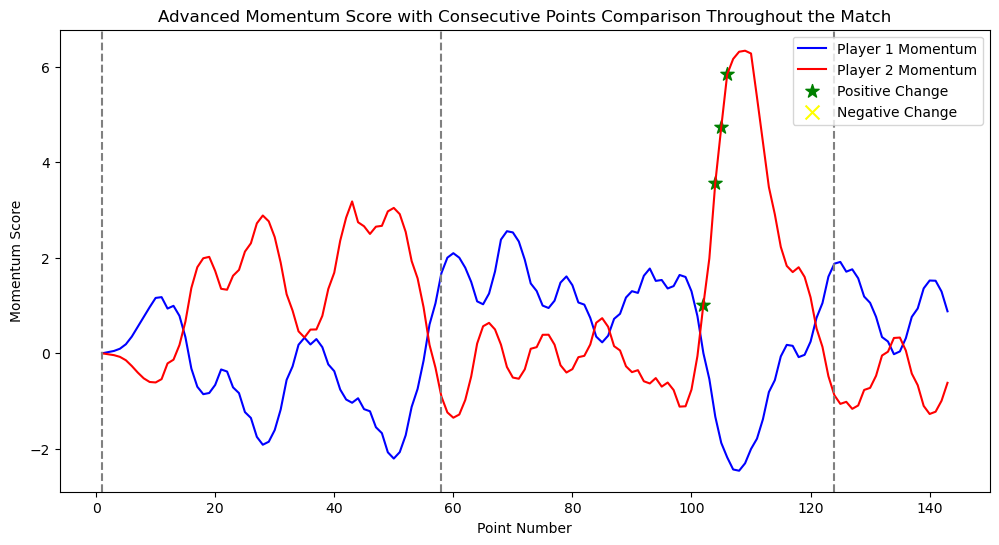

Player 1 had a Negative shift at point number 23, during set 1, game 5. GET -1.0133571697365218
Player 1 had a Positive shift at point number 81, during set 2, game 16. GET 1.1542466453514721
Player 1 had a Positive shift at point number 82, during set 2, game 16. GET 1.0531713914265488
Player 1 had a Positive shift at point number 89, during set 2, game 18. GET 1.0463005139602233
Player 1 had a Positive shift at point number 94, during set 2, game 19. GET 1.0839400403866257
Player 1 had a Negative shift at point number 95, during set 2, game 19. GET -1.4748145738634424
Player 1 had a Negative shift at point number 96, during set 2, game 19. GET -1.3686333282809624
Player 1 had a Negative shift at point number 97, during set 2, game 19. GET -1.3331815304960601
Player 1 had a Negative shift at point number 98, during set 2, game 19. GET -1.3229581683212173
Player 1 had a Negative shift at point number 99, during set 2, game 19. GET -1.3450684538509012


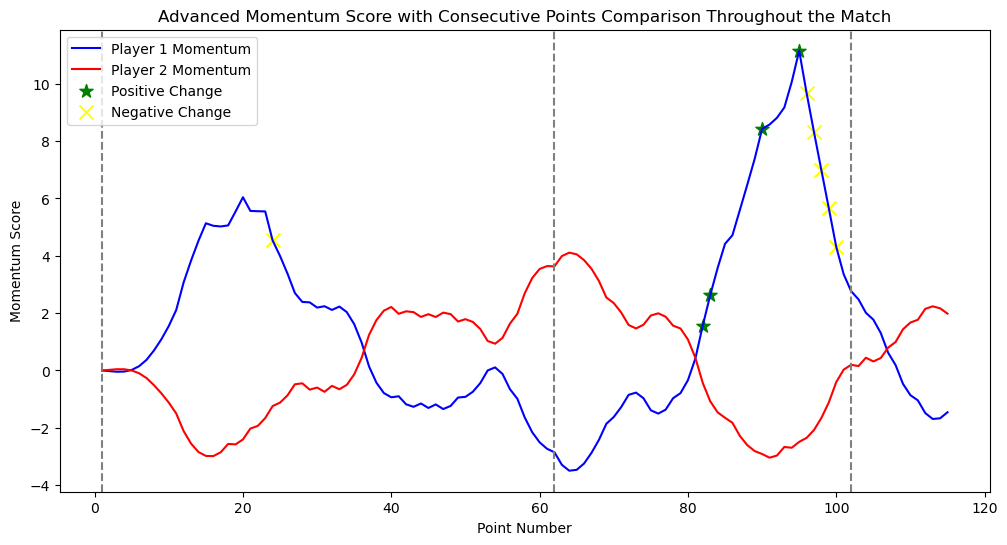

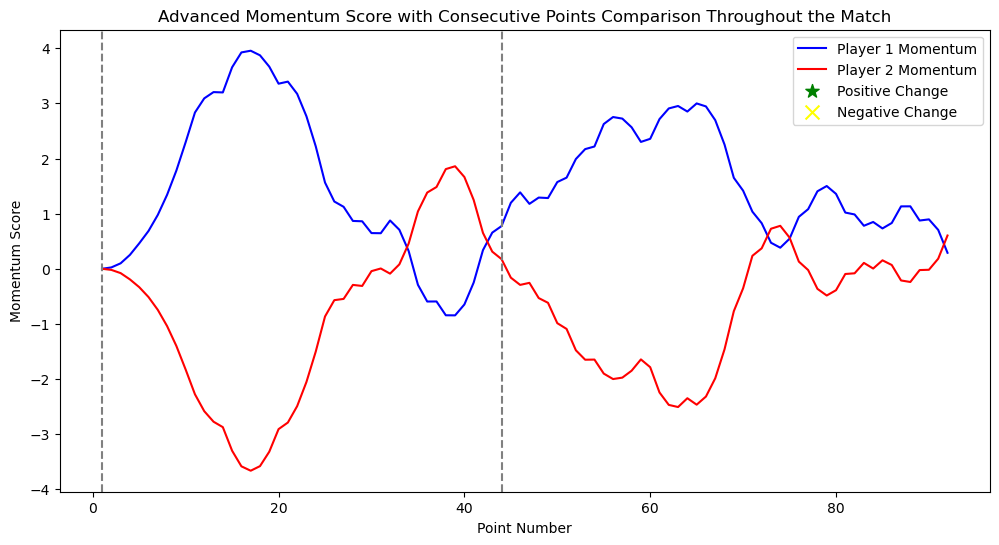

Player 1 had a Positive shift at point number 71, during set 2, game 15. GET 1.0713676028314434
Player 1 had a Positive shift at point number 74, during set 2, game 15. GET 1.0955788912476097


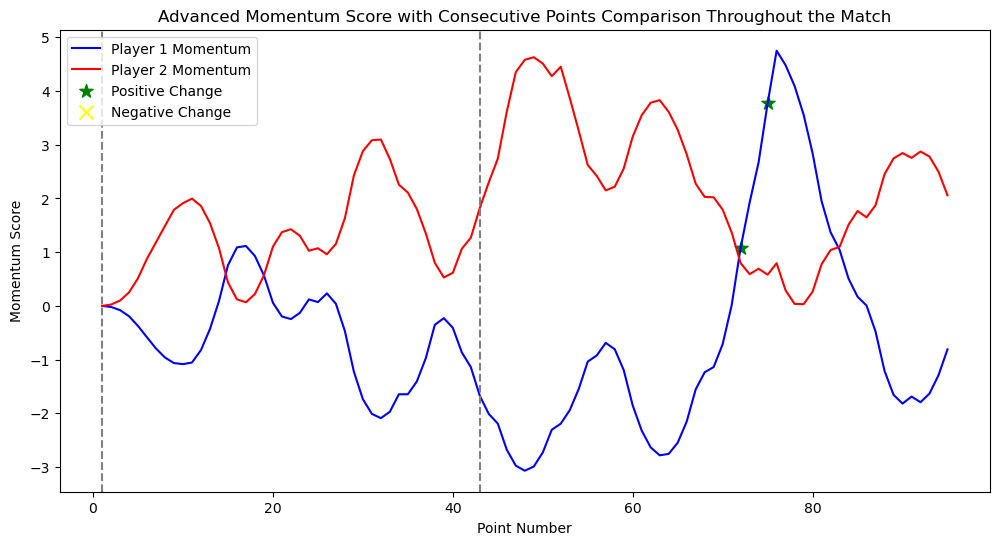

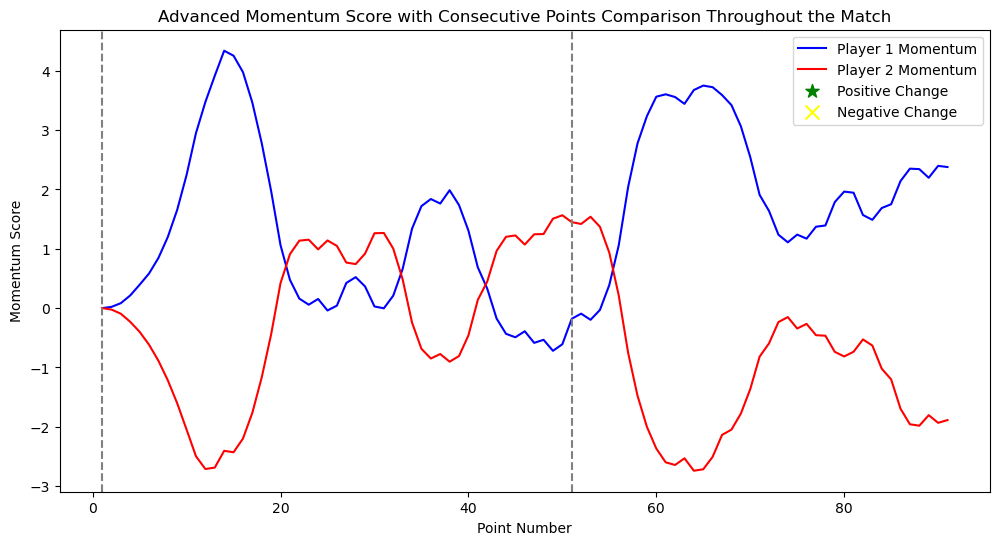

Player 1 had a Positive shift at point number 18, during set 1, game 4. GET 1.027889198324249
Player 1 had a Positive shift at point number 71, during set 2, game 14. GET 1.0593248472969545
Player 2 had a Positive shift at point number 102, during set 2, game 20. GET 1.2288983141152567
Player 2 had a Positive shift at point number 105, during set 2, game 20. GET 1.0820302209806458
Player 2 had a Negative shift at point number 112, during set 2, game 21. GET -1.0269517259338046
Player 2 had a Negative shift at point number 113, during set 2, game 22. GET -1.0091795910967605


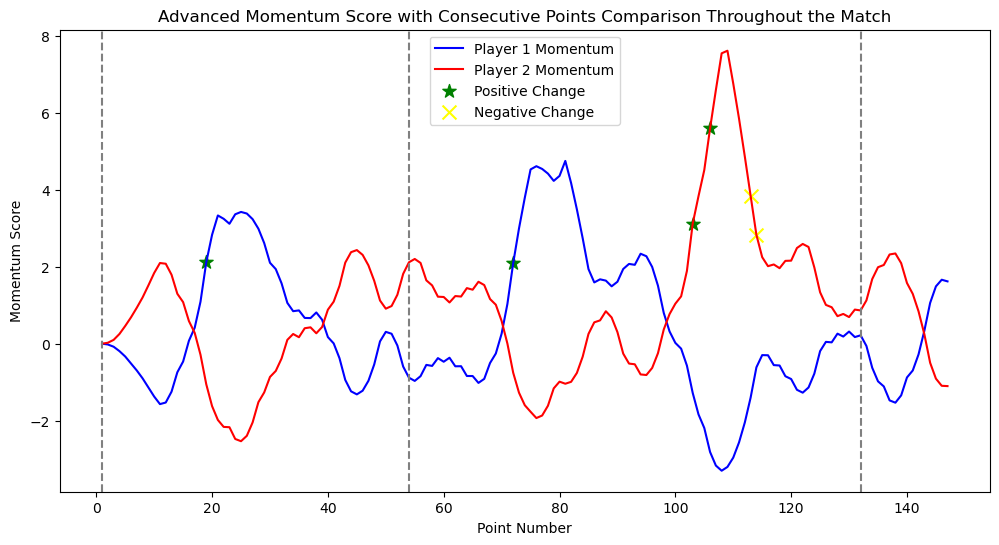

Player 1 had a Positive shift at point number 28, during set 1, game 6. GET 1.1383442485958022
Player 1 had a Positive shift at point number 29, during set 1, game 6. GET 1.198293685002064


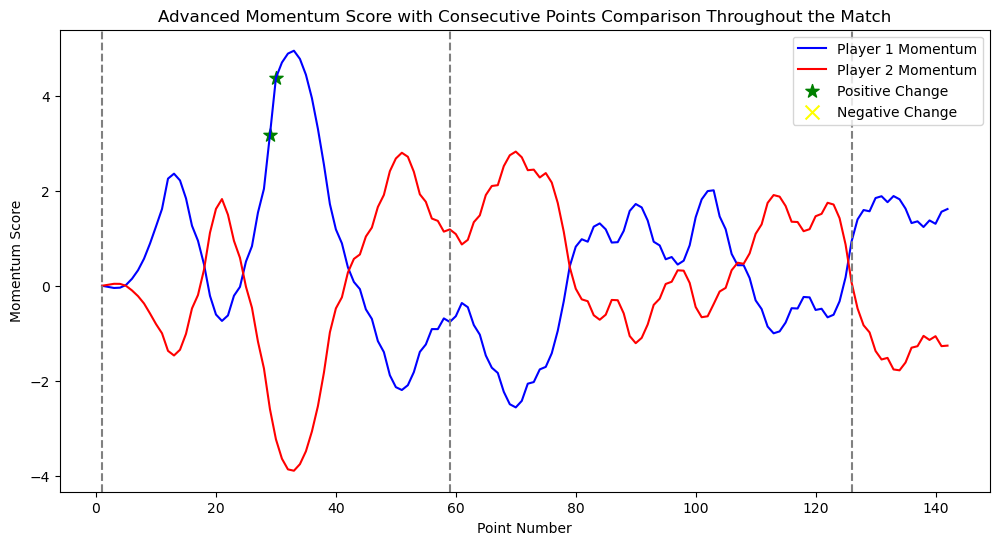

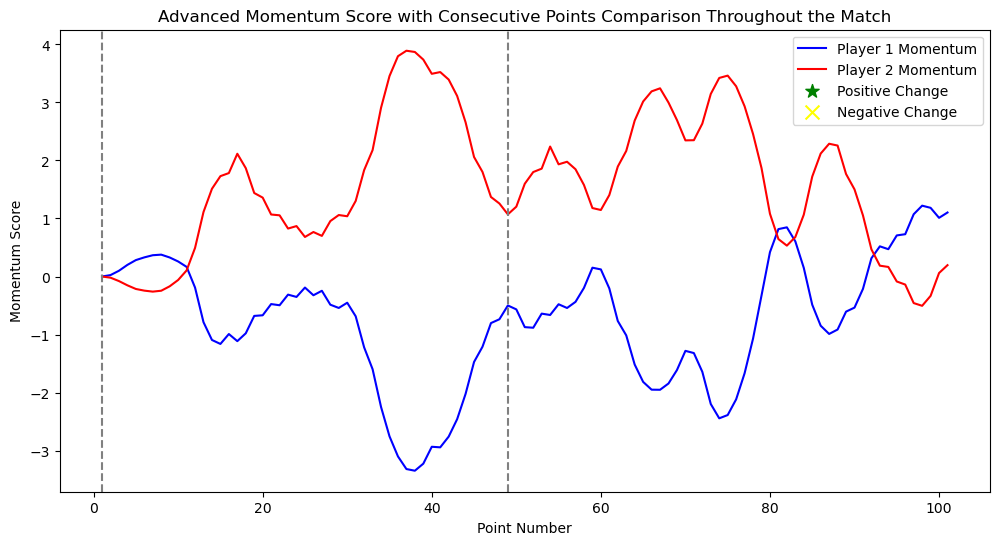

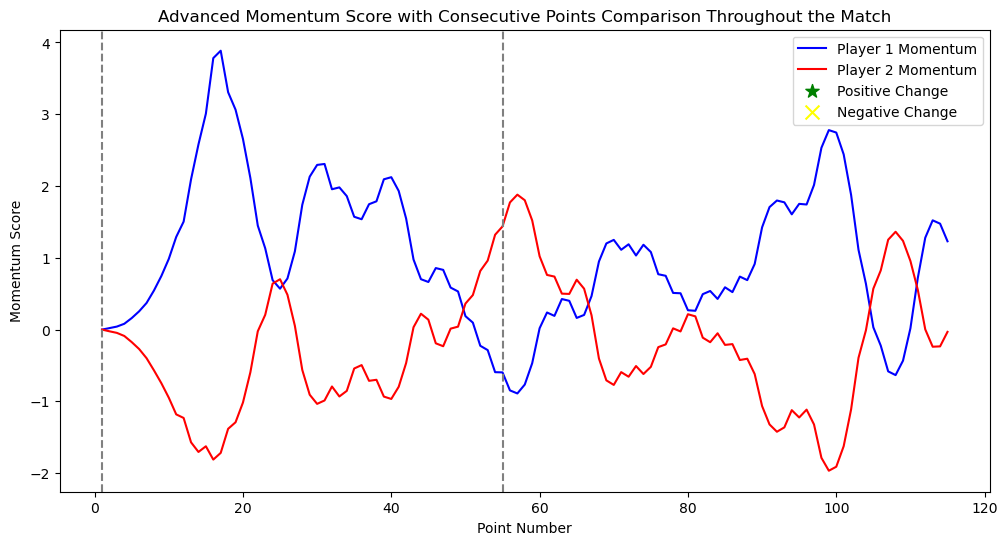

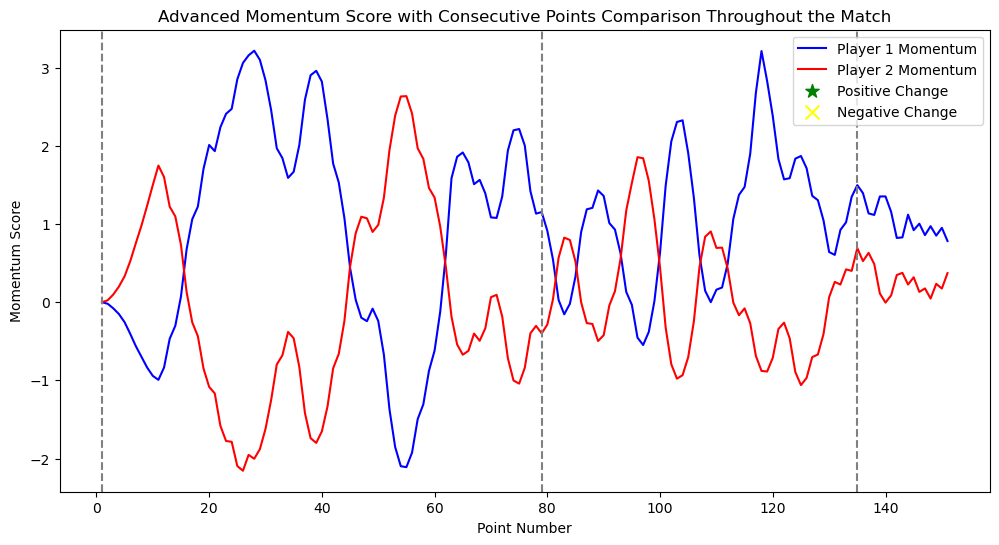

Player 1 had a Negative shift at point number 41, during set 1, game 9. GET -1.4115911687581582
Player 1 had a Negative shift at point number 42, during set 1, game 9. GET -1.4068479902660291
Player 1 had a Negative shift at point number 44, during set 1, game 9. GET -1.0488783916642186
Player 1 had a Negative shift at point number 45, during set 1, game 9. GET -1.1045075715262795
Player 1 had a Negative shift at point number 46, during set 1, game 9. GET -1.2075595159092338


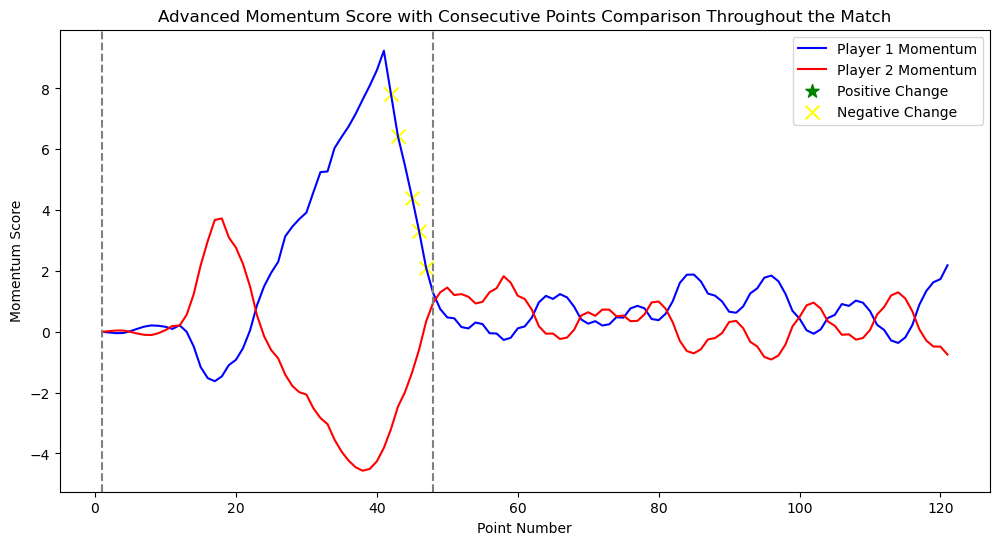

Player 2 had a Positive shift at point number 82, during set 2, game 15. GET 1.0482456762843306


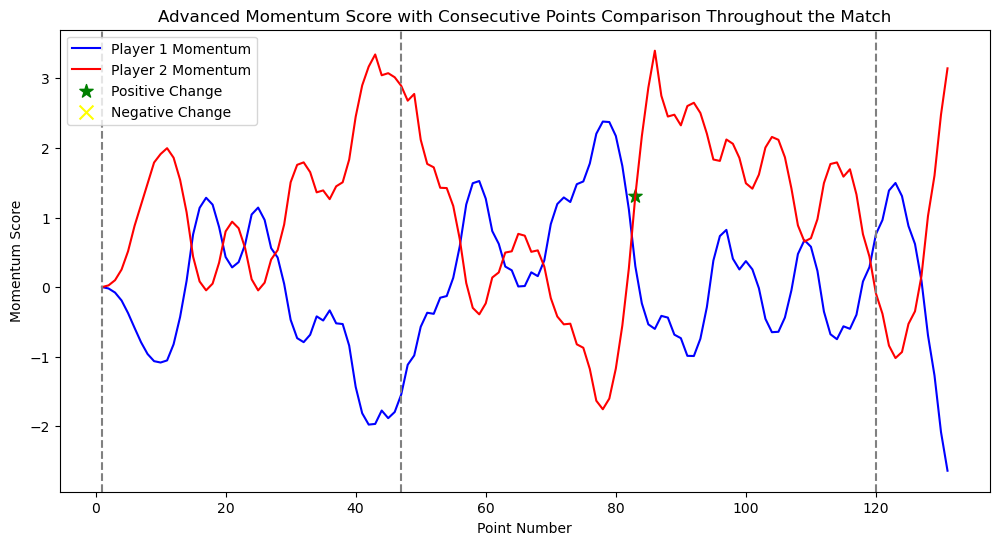

Player 1 had a Positive shift at point number 48, during set 1, game 9. GET 1.0245504612887038
Player 1 had a Negative shift at point number 63, during set 2, game 12. GET -1.0439074519196194
Player 1 had a Negative shift at point number 64, during set 2, game 13. GET -1.1038319252699051


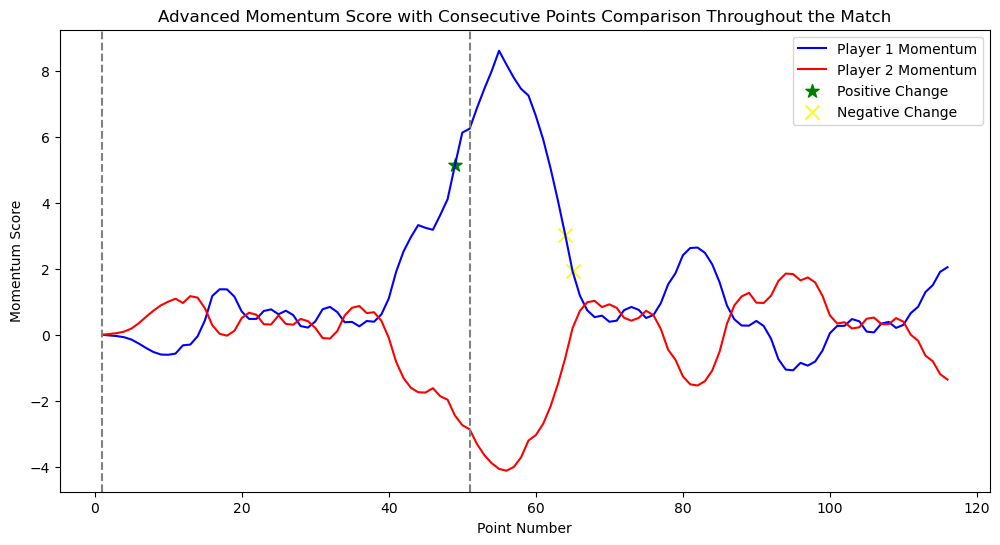

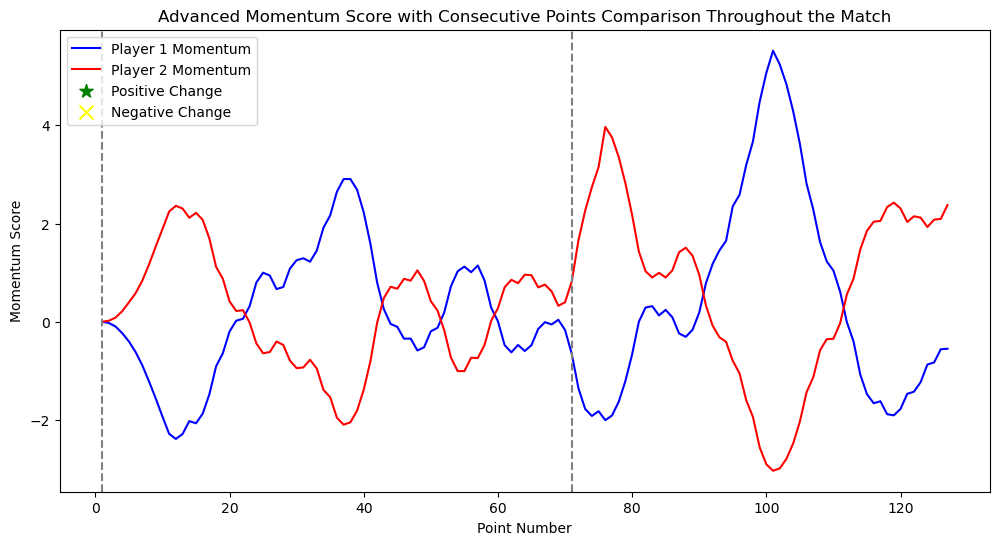

Player 1 had a Positive shift at point number 52, during set 2, game 11. GET 1.059630882038487
Player 2 had a Positive shift at point number 40, during set 2, game 9. GET 1.5598097262171517
Player 2 had a Positive shift at point number 41, during set 2, game 9. GET 1.9135610626309232
Player 2 had a Positive shift at point number 42, during set 2, game 9. GET 1.5005101848279079
Player 2 had a Positive shift at point number 43, during set 2, game 9. GET 1.708816711265932
Player 2 had a Negative shift at point number 47, during set 2, game 10. GET -1.3383089704854214
Player 2 had a Negative shift at point number 48, during set 2, game 10. GET -1.309912821741639
Player 2 had a Negative shift at point number 49, during set 2, game 10. GET -1.318265805669406
Player 2 had a Negative shift at point number 50, during set 2, game 10. GET -1.3490044434740147
Player 2 had a Negative shift at point number 51, during set 2, game 10. GET -1.3350262847758847
Player 2 had a Negative shift at point numb

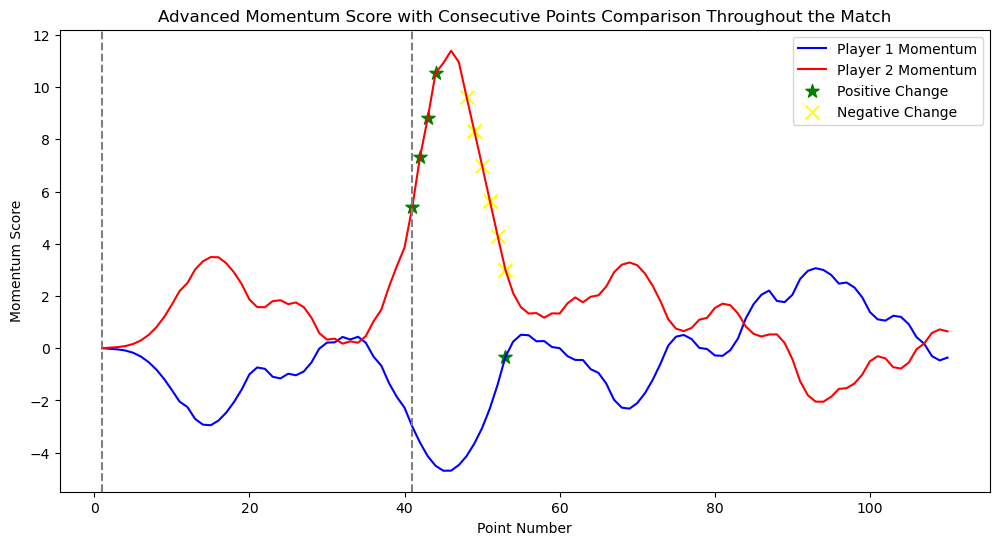

Player 2 had a Positive shift at point number 14, during set 1, game 3. GET 1.132057877223343
Player 2 had a Positive shift at point number 15, during set 1, game 3. GET 1.0185990737754316


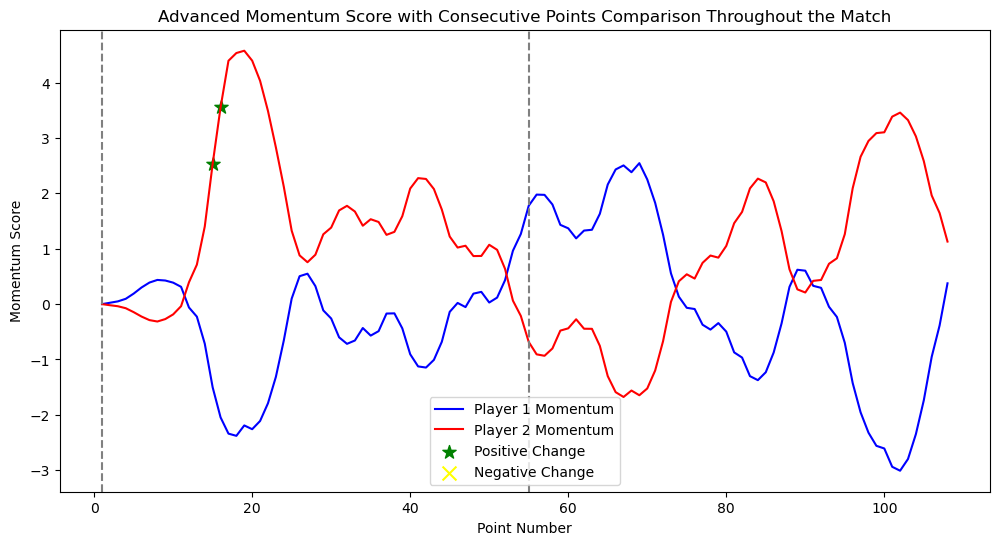

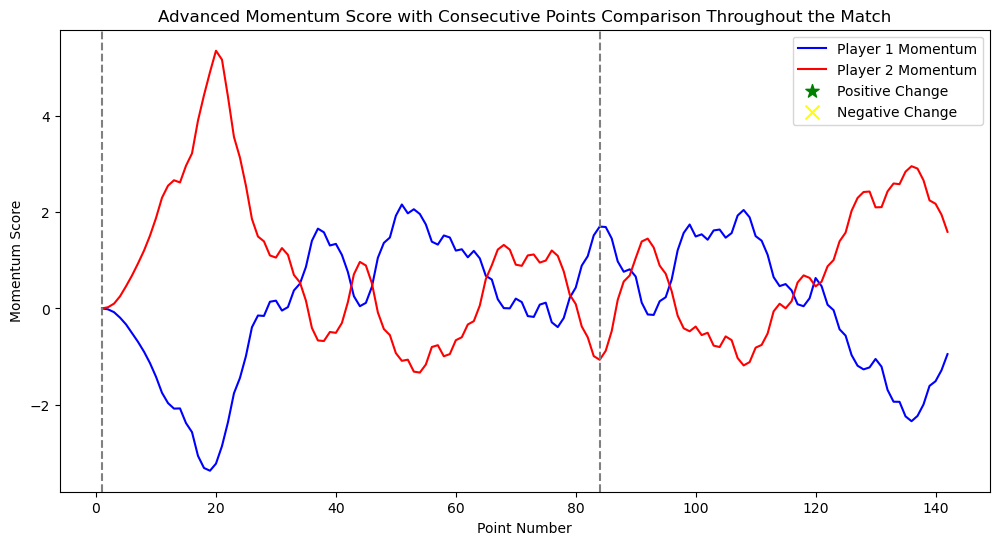

Player 1 had a Positive shift at point number 29, during set 1, game 7. GET 1.000227147120642
Player 1 had a Positive shift at point number 33, during set 1, game 7. GET 1.0244374865641293
Player 1 had a Negative shift at point number 45, during set 2, game 10. GET -1.181771425601025
Player 1 had a Negative shift at point number 46, during set 2, game 10. GET -1.091735057425403
Player 1 had a Negative shift at point number 47, during set 2, game 10. GET -1.0057705711965133
Player 1 had a Negative shift at point number 51, during set 2, game 11. GET -1.0290492848292923
Player 1 had a Positive shift at point number 76, during set 2, game 15. GET 1.1650893929538348


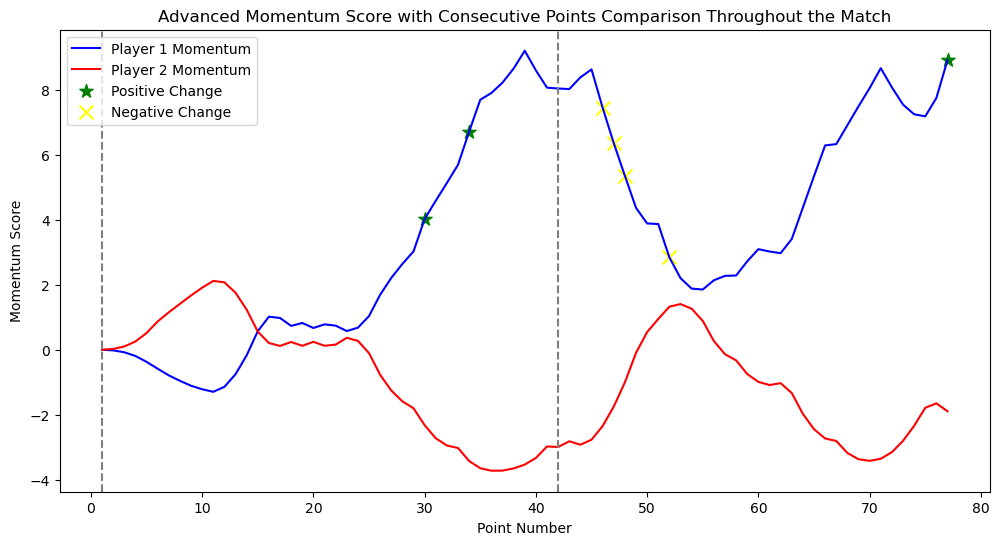

Player 1 had a Positive shift at point number 11, during set 1, game 3. GET 1.0766662503180155
Player 2 had a Positive shift at point number 111, during set 3, game 19. GET 1.1804165208572694
Player 2 had a Negative shift at point number 119, during set 3, game 19. GET -1.0469479149496101


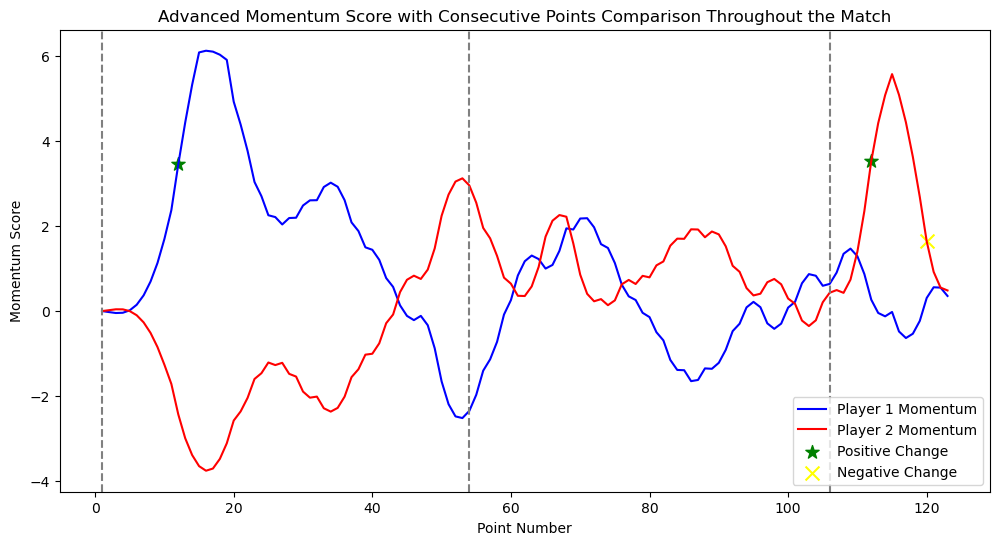

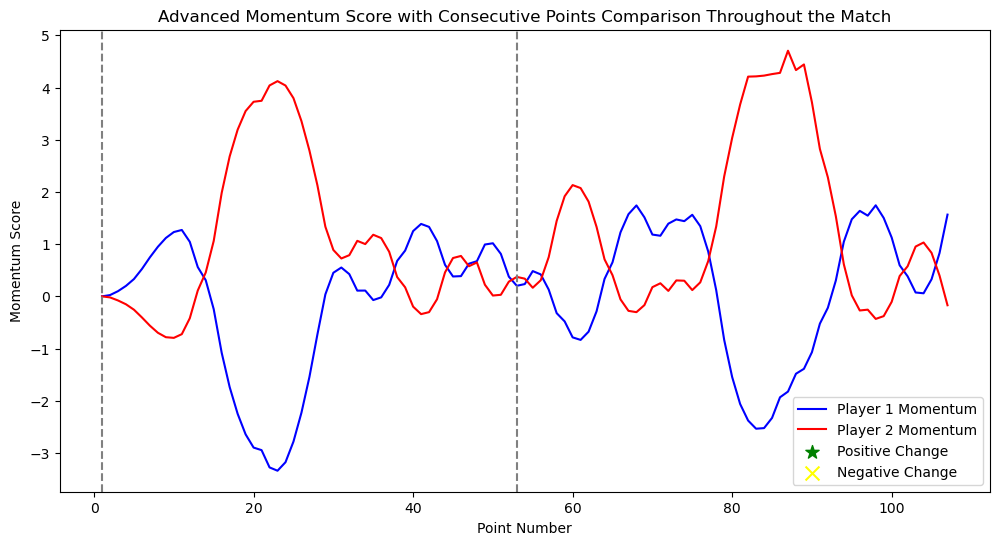

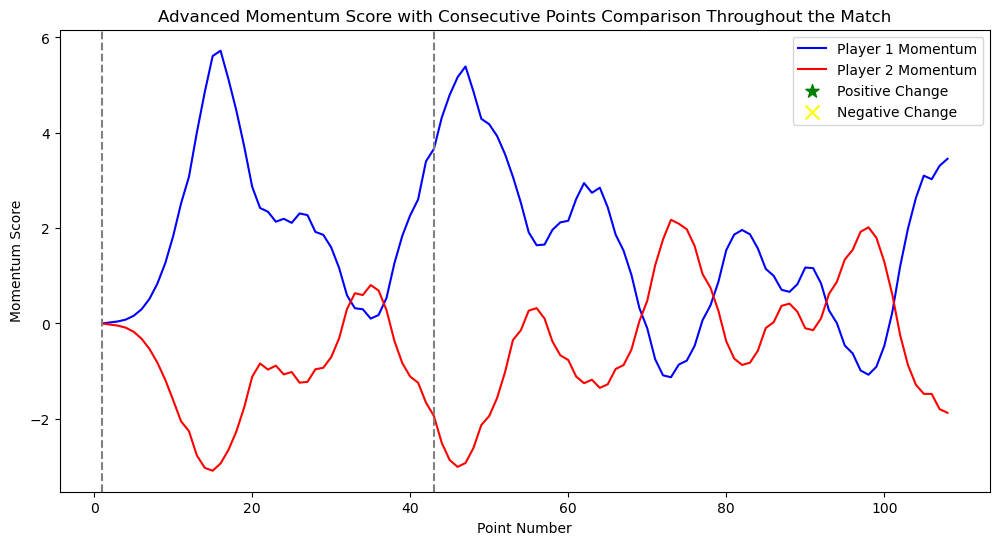

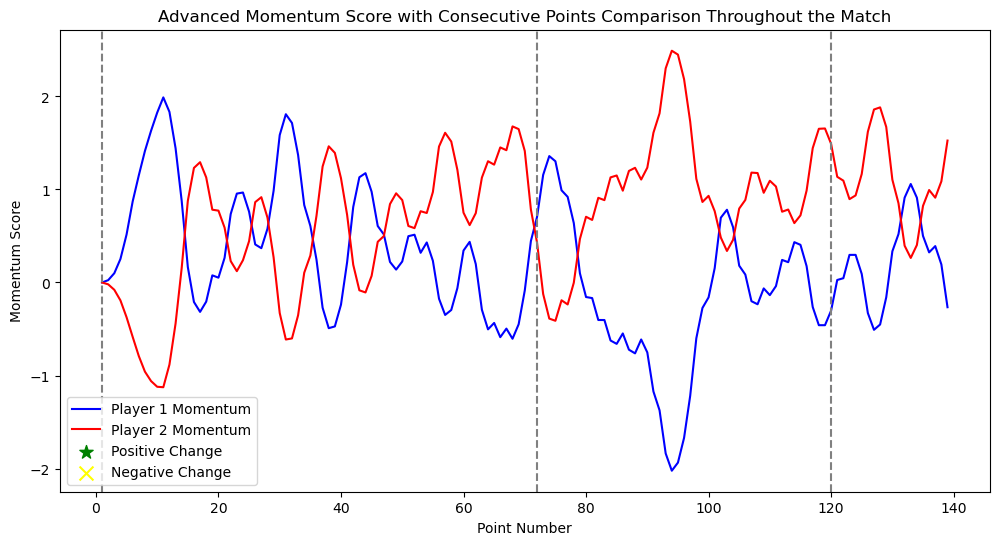

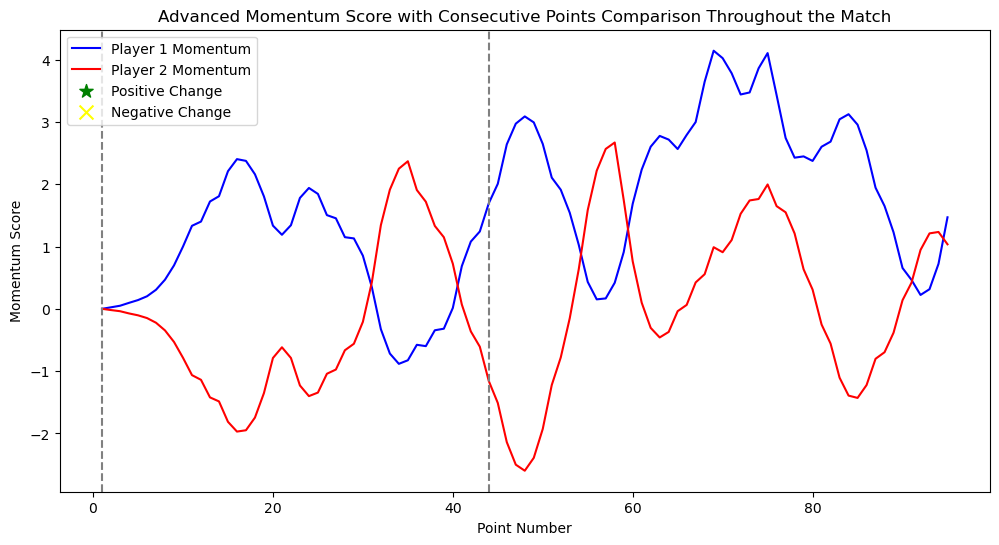

Player 1 had a Positive shift at point number 45, during set 1, game 9. GET 1.2736301427117425
Player 1 had a Positive shift at point number 46, during set 1, game 9. GET 1.092748132783453
Player 1 had a Positive shift at point number 47, during set 1, game 9. GET 1.0436044932948074
Player 1 had a Negative shift at point number 55, during set 2, game 11. GET -1.0496196993182654
Player 1 had a Negative shift at point number 56, during set 2, game 11. GET -1.1429397310794247
Player 1 had a Negative shift at point number 57, during set 2, game 11. GET -1.2085946952321138
Player 1 had a Negative shift at point number 60, during set 2, game 12. GET -1.1133137210833457


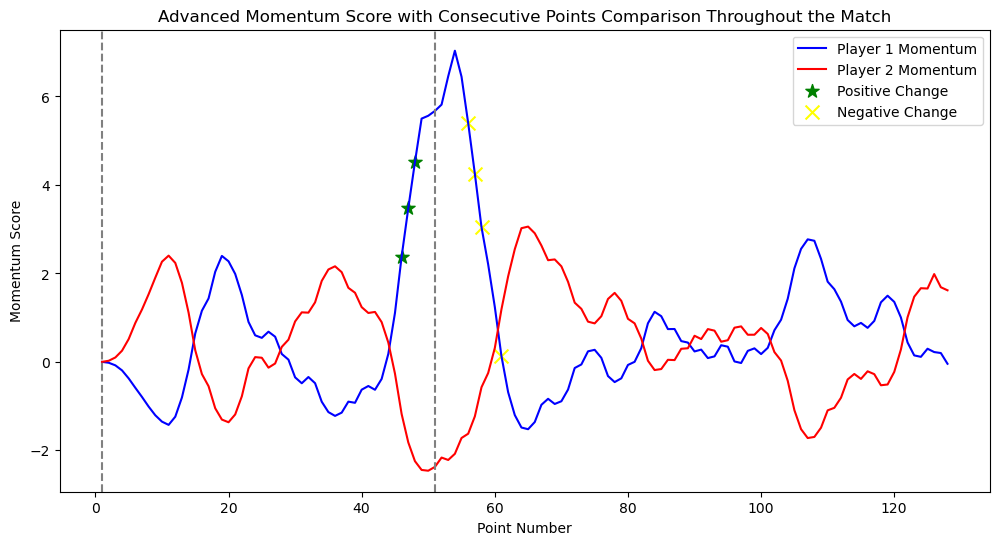

Player 2 had a Negative shift at point number 102, during set 2, game 17. GET -1.0668979140674688


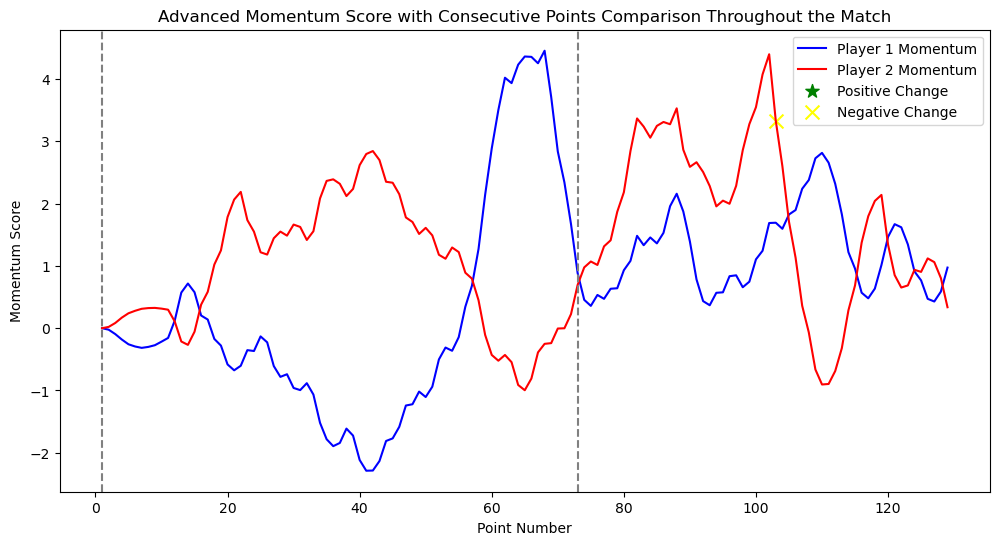

Player 1 had a Positive shift at point number 111, during set 2, game 20. GET 1.107075531157176


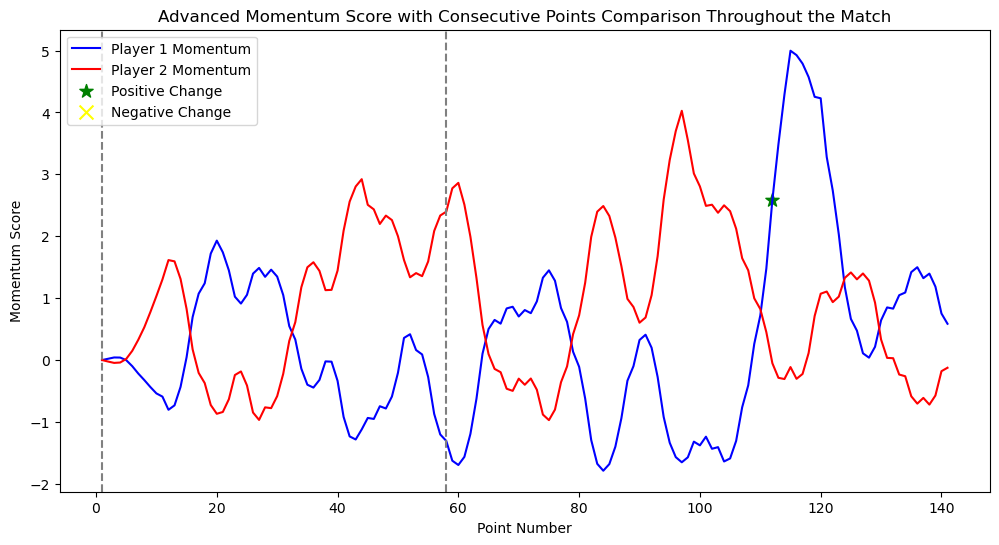

Player 1 had a Positive shift at point number 83, during set 2, game 16. GET 1.1657993662476827
Player 1 had a Positive shift at point number 84, during set 2, game 16. GET 1.1561875664413286
Player 1 had a Positive shift at point number 85, during set 2, game 16. GET 1.1696825926939782
Player 1 had a Positive shift at point number 91, during set 2, game 17. GET 1.3158346833025796
Player 1 had a Negative shift at point number 93, during set 2, game 18. GET -1.7096540750687943
Player 1 had a Negative shift at point number 94, during set 2, game 18. GET -1.6059950438199282
Player 1 had a Negative shift at point number 95, during set 2, game 18. GET -1.5218944638777474


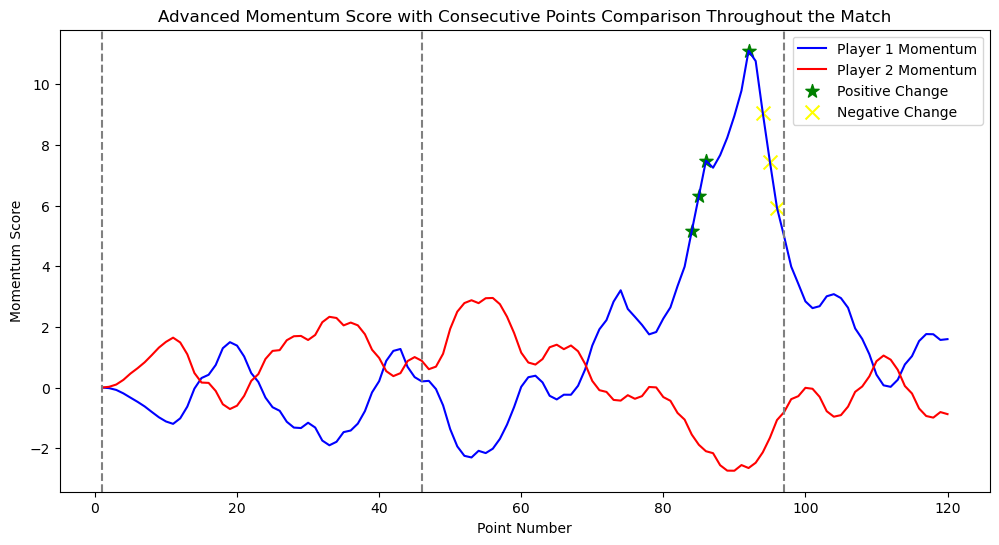

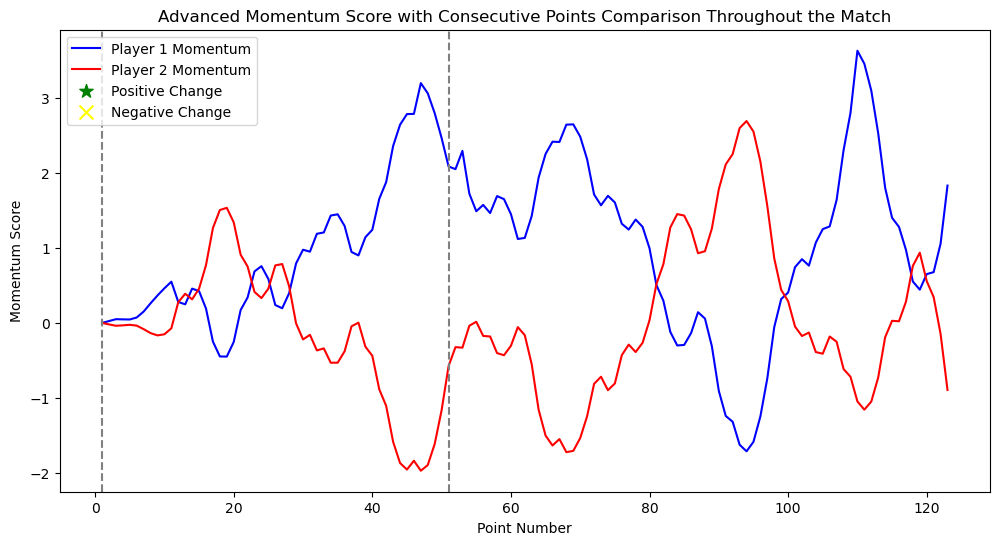

Player 1 had a Positive shift at point number 43, during set 1, game 9. GET 1.1145648089182596
Player 2 had a Positive shift at point number 29, during set 1, game 6. GET 1.0103969986251933
Player 2 had a Positive shift at point number 31, during set 1, game 7. GET 1.0283756825686536
Player 2 had a Negative shift at point number 35, during set 1, game 7. GET -1.0503936390542528
Player 2 had a Negative shift at point number 36, during set 1, game 7. GET -1.16999138886476


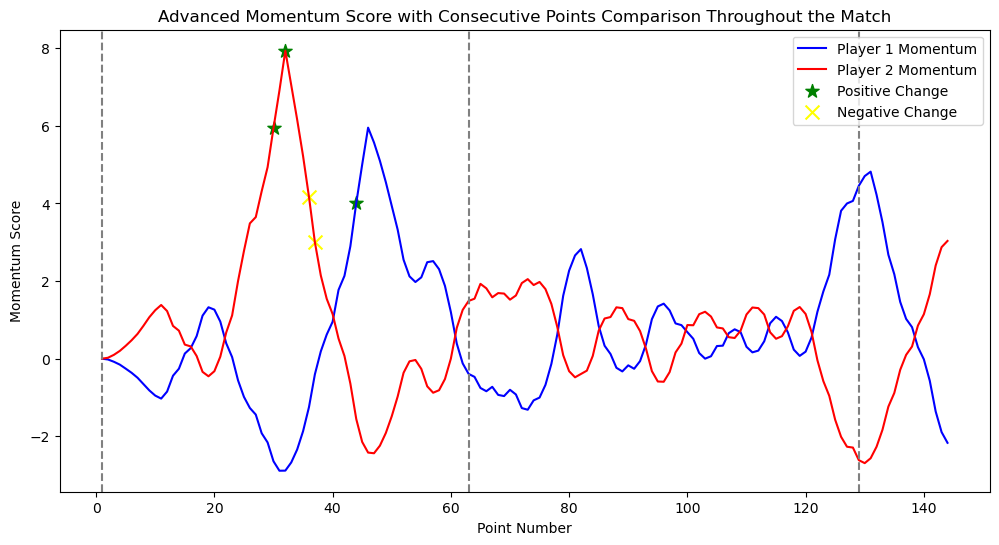

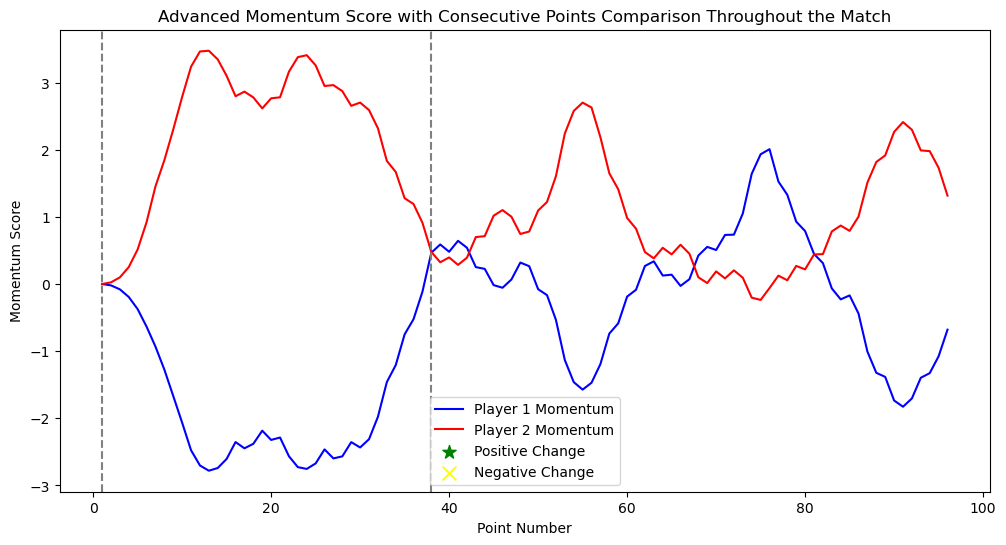

Player 1 had a Positive shift at point number 43, during set 1, game 8. GET 1.027619617737682
Player 1 had a Positive shift at point number 44, during set 1, game 8. GET 1.2584505880163959
Player 2 had a Positive shift at point number 88, during set 2, game 17. GET 1.0166126972591156
Player 2 had a Negative shift at point number 94, during set 2, game 18. GET -1.1869652427929216
Player 2 had a Negative shift at point number 95, during set 2, game 18. GET -1.153938532011897


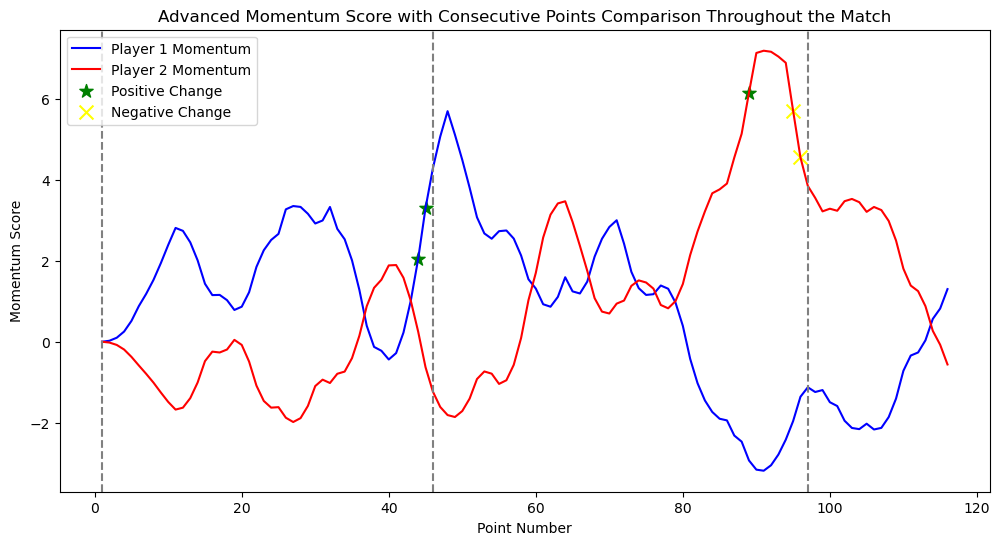

In [9]:
"""
画图
"""
target_match_ids = updated_ausopen_data['match_id'].unique().tolist()
for target_match_id in target_match_ids:
    # 筛选数据
    filtered_data = updated_ausopen_data[updated_ausopen_data['match_id'] == target_match_id].copy()

    # 计算综合势头得分
    filtered_data['comprehensive_momentum_1'] = calculate_comprehensive_momentum(filtered_data, player_number=1)
    filtered_data['comprehensive_momentum_2'] = calculate_comprehensive_momentum(filtered_data, player_number=2)

    # Define the threshold for a significant momentum shift
    threshold = 1.0

    # Initialize lists to store the points of positive and negative shifts for both players
    shifts_player_1 = []
    shifts_player_2 = []

    # Calculate the momentum change for each point and find shifts
    for i in range(1, len(filtered_data)):
        change_1 = filtered_data['comprehensive_momentum_1'].iloc[i] - filtered_data['comprehensive_momentum_1'].iloc[
            i - 1]
        change_2 = filtered_data['comprehensive_momentum_2'].iloc[i] - filtered_data['comprehensive_momentum_2'].iloc[
            i - 1]

        if abs(change_1) >= threshold:
            shift_type = 'Positive' if change_1 > 0 else 'Negative'
            shifts_player_1.append((i, shift_type, change_1))
        if abs(change_2) >= threshold:
            shift_type = 'Positive' if change_2 > 0 else 'Negative'
            shifts_player_2.append((i, shift_type, change_2))

    # Annotation
    for point, shift_type, change in shifts_player_1:
        set_no = filtered_data['set_no'].iloc[point]
        game_no = filtered_data['game_no'].iloc[point]
        print(
            f"Player 1 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")

    for point, shift_type, change in shifts_player_2:
        set_no = filtered_data['set_no'].iloc[point]
        game_no = filtered_data['game_no'].iloc[point]
        print(
            f"Player 2 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")

    # # 筛选出破发成功的点（缺失）
    # break_points_won_1 = filtered_data[filtered_data['p1_break_pt_won'] == 1]
    # break_points_won_2 = filtered_data[filtered_data['p2_break_pt_won'] == 1]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_1'], label='Player 1 Momentum',
             color='blue')
    plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_2'], label='Player 2 Momentum',
             color='red')

    plt.scatter([], [], color='green', marker='*', s=100, label='Positive Change')
    plt.scatter([], [], color='yellow', marker='x', s=100, label='Negative Change')

    for point, shift_type, _ in shifts_player_1:
        marker = '*' if shift_type == 'Positive' else 'x'
        color = 'green' if shift_type == 'Positive' else 'yellow'
        plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point],
                    color=color, marker=marker, s=100)

    for point, shift_type, _ in shifts_player_2:
        marker = '*' if shift_type == 'Positive' else 'x'
        color = 'green' if shift_type == 'Positive' else 'yellow'
        plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_2'].iloc[point],
                    color=color, marker=marker, s=100)

    # # 用黑色点标记破发成功的点（缺失）
    # plt.scatter(break_points_won_1['point_no'], break_points_won_1['comprehensive_momentum_1'], color='black',
    #             marker='o', label='Player 1 Break Points Won')
    # plt.scatter(break_points_won_2['point_no'], break_points_won_2['comprehensive_momentum_2'], color='black',
    #             marker='s', label='Player 2 Break Points Won')

    # 添加盘结束的垂直线
    last_set_no = 0
    for i, row in filtered_data.iterrows():
        if row['set_no'] != last_set_no:
            plt.axvline(x=row['point_no'], color='grey', linestyle='--')
            last_set_no = row['set_no']

    # Add labels and title to the plot
    plt.xlabel('Point Number')
    plt.ylabel('Momentum Score')
    plt.title('Advanced Momentum Score with Consecutive Points Comparison Throughout the Match')
    plt.legend()
    plt.show()